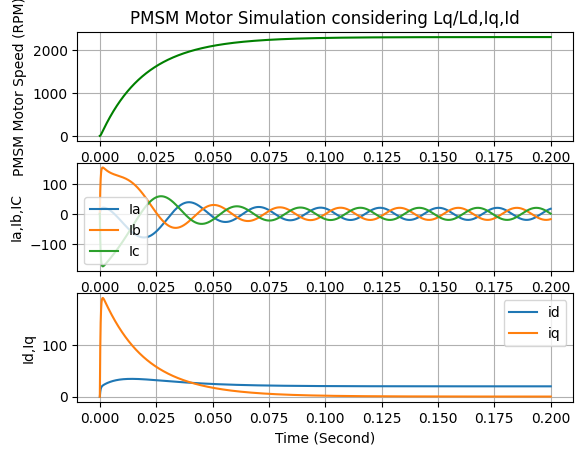

In [3]:
# Import Library
import numpy as np
import matplotlib.pyplot as plt

# Motor parameters (replace with actual values)
Rs = 0.5             # Stator resistance (ohms)
Ld = 0.00015          # d-axis inductance (H)
Lq = 0.00015          # q-axis inductance (H)
J = 0.01             # Rotor inertia (kg.m^2)
B = 0.001            # Damping coefficient (N.m.s)
lambda_f = 0.1       # Flux linkage (Wb)
p = 4                # Number of pole pairs

# Function to convert Vq,Vd to Va,Vb,Vc 
def dq_to_abc(Vd, Vq, theta):
    # Inverse Park Transformation (d-q to alpha-beta frame)
    V_alpha = Vd * np.cos(theta) - Vq * np.sin(theta)
    V_beta = Vd * np.sin(theta) + Vq * np.cos(theta)
    
    # Inverse Clarke Transformation (alpha-beta to a-b-c frame)
    Va = V_alpha
    Vb = -0.5 * V_alpha + (np.sqrt(3) / 2) * V_beta
    Vc = -0.5 * V_alpha - (np.sqrt(3) / 2) * V_beta
    
    return Va, Vb, Vc

# Function to convert Va,Vb,Vc to Vq,Vd 
def abc_to_dq(Va, Vb, Vc, theta):
    # Clarke Transformation (3-phase to alpha-beta frame)
    V_alpha = Va
    V_beta = (1 / np.sqrt(3)) * (Va + 2 * Vb)
    
    # Park Transformation (alpha-beta to d-q frame)
    Vd = V_alpha * np.cos(theta) + V_beta * np.sin(theta)
    Vq = -V_alpha * np.sin(theta) + V_beta * np.cos(theta)
    
    return Vd, Vq

# PMSM motor equations and solution using Eular Method
# Input :   1.  Pmsm motor state Iq and omega_m
#           2.  sampel time dt
#           3.  Vq_ref
#           4.  Load Torque Tl
# Ouput :  New Values of Iq (Q axis current) and omega_m (Motor Speed)

def pmsm_dynamics(dt,motor_state,motor_input,load_torque=0):
    # State variables
    Id, Iq, omega_m, theta = motor_state
    #input Va,Vb,VC
    Va,Vb,Vc=motor_input
    # Load Torque
    Tl=load_torque

    # Convert Mech omega to Electricl omega
    omega_e = p * omega_m

    # Convert Va,Vb,Vc to Vq,Vd
    Vd,Vq=abc_to_dq(Va,Vb,Vc,theta)

    # d-q axis currents (id and iq) dynamics
    did_dt = (Vd - Rs * Id + omega_e * Lq * Iq) / Ld
    diq_dt = (Vq - Rs * Iq - omega_e * Ld * Id - omega_e * lambda_f) / Lq
    Id = Id + did_dt*dt
    Iq = Iq + diq_dt*dt

    # Electromagnetic torque
    Te = (3/2) * p * lambda_f * Iq

    # Mechanical dynamics
    domega_dt = (Te - Tl - B * omega_m) / J
    omega_m = omega_m + domega_dt*dt
    theta = theta + omega_m * dt
    
    return [Id,Iq,omega_m,theta]

# Simulation parameters
t_span = 0.2 # Simulation time
dt = 1e-6  # Time step
t_eval=np.arange(0, t_span, dt)
time_len=len(t_eval)

# Initial conditions [id,iq,omega,theta]
state0 = [0, 0, 0, 0]  

# np arrays for storing result
id=np.zeros(time_len)
iq=np.zeros(time_len) 
omega=np.zeros(time_len)
theta=np.zeros(time_len)

Ia=np.zeros(time_len)
Ib=np.zeros(time_len)
Ic=np.zeros(time_len)

# Motor input voltage ref Vq_ref and load torque
Vq_ref=100
Vd_ref=10
Tl=0.001

# Calculate motor performance 
index=0
Va,Vb,Vc=dq_to_abc(Vd=Vd_ref,Vq=Vq_ref,theta=0)

for t in t_eval[:(time_len-1)]:
    Vabc=dq_to_abc(Vd_ref, Vq_ref, theta[index])
    state0=pmsm_dynamics(dt=dt,motor_state=state0,motor_input=Vabc,load_torque=Tl)
    
    index=index+1
    id[index], iq[index], omega[index], theta[index] = state0
    
        
# Calculate Ia,Ib and Ic for Iq, theta arrary and Id=0  
Ia,Ib,Ic=dq_to_abc(id,iq,theta) 

# Plot PMSM speed/Currents vs Time
plt.figure(1)
plt.tight_layout()

plt.subplot(3,1,1)
plt.plot(t_eval, omega*60/(2*np.pi), label='omega in rpm', color="g")
plt.title("PMSM Motor Simulation considering Lq/Ld,Iq,Id")
plt.ylabel("PMSM Motor Speed (RPM)")
plt.grid()

plt.subplot(3,1,2)
plt.plot(t_eval, Ia, label='Ia')
plt.plot(t_eval, Ib, label='Ib')
plt.plot(t_eval, Ic, label='Ic')
plt.ylabel("Ia,Ib,IC")
plt.legend()
plt.grid()

plt.subplot(3,1,3)
plt.plot(t_eval, id, label='Id')
plt.plot(t_eval, iq, label='Iq')

plt.xlabel("Time (Second)")
plt.ylabel("Id,Iq")
plt.grid()
plt.legend()
plt.show()